In [21]:
import torch
import librosa
import os
from torch.utils.data import DataLoader
import torchaudio
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import scipy
from acustic_locating_vq_vae.rir_dataset_generator.speech_dataset import speech_DATASET
from acustic_locating_vq_vae.visualization import plot_spectrogram, real_spec_to_complex
from acustic_locating_vq_vae.data_preprocessing import batchify_spectrograms
from IPython.display import Audio, display



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
model = torch.load('/home/guy/PycharmProjects/Acoustic_Locating_VQ-VAE/models/model_speech.pt')

In [13]:
fs = 16e3
dataset_path = os.path.join(os.getcwd(), "data")
batch_size = 1

In [29]:
def sound_from_sample(data, fs, NFFT, noverlap):
    fs = int(fs)
    S = scipy.signal.istft(data, nperseg=NFFT, noverlap=noverlap, fs=fs)
    scaled = np.int16(S / np.max(np.abs(S)) * 32767).T
    return scaled
    # write(filename, fs, scaled)

In [15]:
DATASET_PATH = '/home/guy/PycharmProjects/Acoustic_Locating_VQ-VAE/scripts/speech_dataset/dev_data'
BATCH_SIZE = 1
LR = 1e-3  # as is in the speach article
SAMPLING_RATE = 16e3
NFFT = int(SAMPLING_RATE*0.025)
IN_FEATURE_SIZE = int((NFFT) + 2)
# IN_FEATURE_SIZE = 80
HOP_LENGTH = int(SAMPLING_RATE * 0.01)
output_features_dim = IN_FEATURE_SIZE
num_hiddens = 512
in_channels = IN_FEATURE_SIZE
num_residual_layers = 10
num_residual_hiddens = 40
embedding_dim = 256
num_embeddings = 1024  # The higher this value, the higher the capacity in the information bottleneck.
commitment_cost = 0.25  # as recommended in VQ VAE article

use_jitter = False
jitter_probability = 0.12

rev = 0.3
olap = 0.75
noverlap = round(olap * NFFT)
train_dataset = speech_DATASET(root_dir=DATASET_PATH, transform=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=lambda x: batchify_spectrograms(x, NFFT, noverlap))

In [53]:
model.eval()

(originals, _) = next(iter(train_loader))
originals = originals.to(device)

_, reconstructions, _ = model(originals)

In [54]:
model(originals)

(tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[ 0.0190, -0.0058, -0.0365,  ..., -0.0277, -0.0143, -0.0563],
          [-0.0206, -0.0084,  0.0214,  ...,  0.0119,  0.0028,  0.0015],
          [ 0.0011,  0.0096, -0.0013,  ..., -0.0013, -0.0191,  0.0168],
          ...,
          [ 0.0010,  0.0014,  0.0022,  ...,  0.0003, -0.0007,  0.0043],
          [ 0.0010, -0.0012, -0.0007,  ...,  0.0008,  0.0054, -0.0014],
          [-0.0002, -0.0006, -0.0007,  ..., -0.0003, -0.0016, -0.0009]]],
        device='cuda:0', grad_fn=<ConvolutionBackward0>),
 tensor(10.8840, device='cuda:0'))

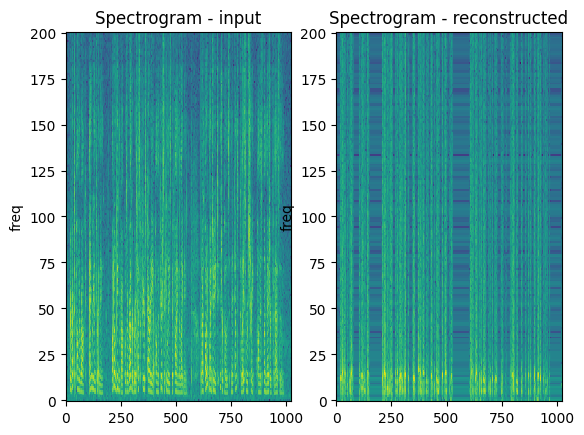

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_spectrogram(real_spec_to_complex(originals[0].detach().to('cpu')), title=f"Spectrogram - input", ylabel="freq", ax=ax1)
plot_spectrogram(real_spec_to_complex(reconstructions[0].detach().to('cpu')), title="Spectrogram - reconstructed", ylabel="freq",ax=ax2)
plt.show()

In [56]:
real_spec = real_spec_to_complex(reconstructions[0].detach().to('cpu'))
sig = sound_from_sample(real_spec, fs, NFFT, noverlap)

display(Audio(sig[:,0], autoplay=True, rate=fs))


In [57]:
sig.shape

(102200, 2)